In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('Advertising.csv').drop(columns="Unnamed: 0")
display(data.head())

,TV,Radio,Newspaper,Sales
0,230.100,37.800,69.200,22.100
1,44.500,39.300,45.100,10.400
2,17.200,45.900,69.300,9.300
3,151.500,41.300,58.500,18.500
4,180.800,10.800,58.400,12.900


In [3]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data.loc[:, 'TV':'Newspaper']
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


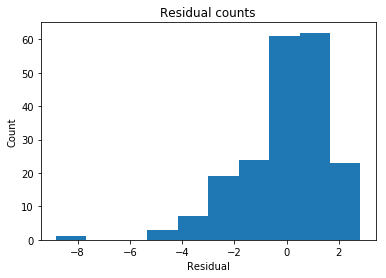

In [4]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

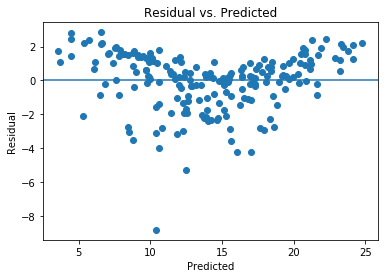

In [5]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


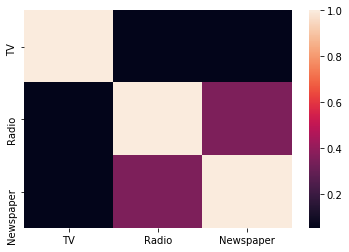

In [6]:
correlation_matrix = X.corr()
display(correlation_matrix)
sns.heatmap(correlation_matrix)
plt.show()

### You can see the correlations here between both TV and Radio with Sales, but it's hard to see much correlation at all with Newspaper and Sales....

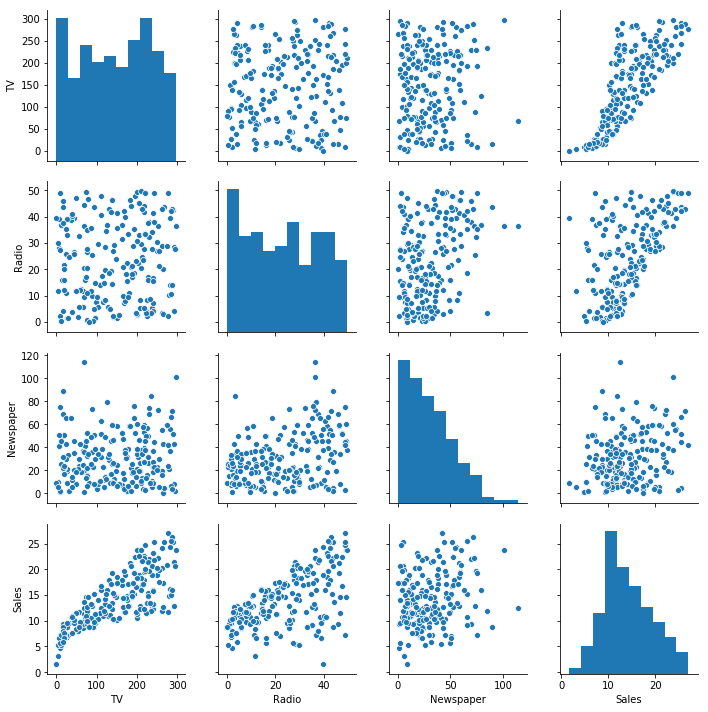

In [7]:
sns.pairplot(data)
plt.show()

### Well, there are a couple outliers in Newspaper, let's see what that does to my multivariate normality

In [8]:
# I just made this into a function to avoid pasting the same code in subsequent cells as I test;
# It's an attempt to keep things slightly tidier.
def boxplotit():
    sns.set_style("ticks")
    sns.set_context("talk", font_scale=0.8)
    fig, axes = plt.subplots(1, 3, figsize=[18,4])
    fig.suptitle("Man's Search for Meaning...  I mean, Outliers", fontweight='bold')
    sns.boxplot(x="TV", data=data, color="darkorange", ax=axes[0])
    sns.boxplot(x="Radio", data=data, color="chocolate", ax=axes[1])
    sns.boxplot(x="Newspaper", data=data, color="firebrick", ax=axes[2])
    plt.show()   

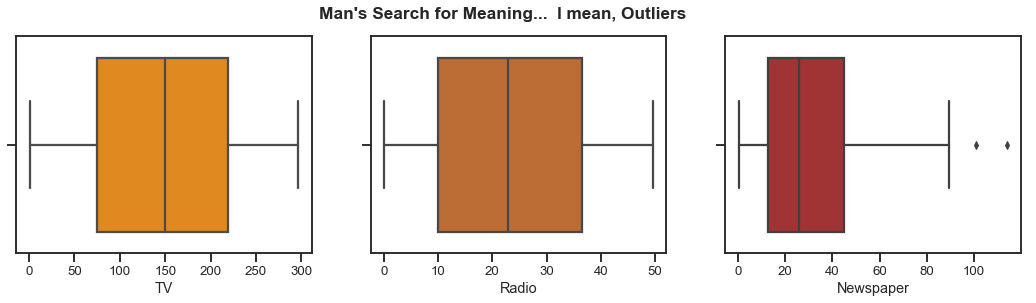

In [9]:
boxplotit() 

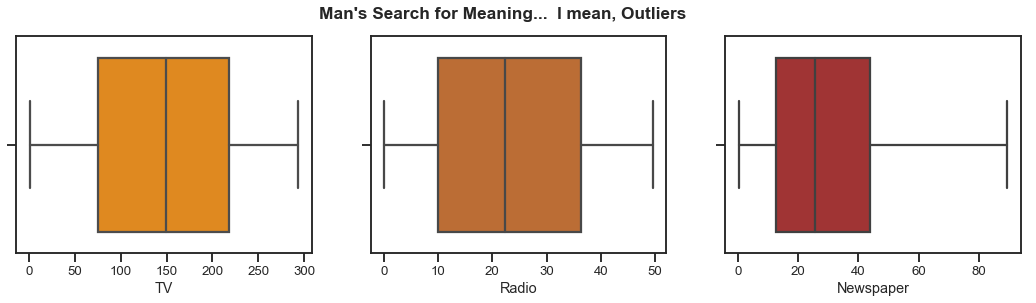

In [10]:
# simple way to get rid of the Newspaper outliers
data = data[data["Newspaper"] < 95]
boxplotit()

In [11]:
# there are a couple outliers that I see on the scatterplots in Radio that I'm concerned about
data[data["Sales"] < 4][["Radio", "Sales"]]

,Radio,Sales
130,39.600,1.600
155,11.600,3.200


In [12]:
# This will get them
data = data[data["Sales"] >= 4]
#data.drop(index=[130,155], inplace=True)

In [13]:
data[(data["Sales"] < 8) & (data["Radio"] > 45)][["Radio", "Sales"]]

,Radio,Sales
5,48.900,7.200


In [14]:
data.drop(index=5, inplace=True)

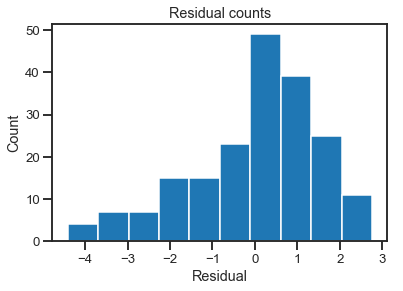

In [15]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data.loc[:, 'TV':'Newspaper']
regr.fit(X, Y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### I was using this function to try a bunch of different transformations, but ended up just doing individual transformations

In [16]:
def transformations(column):    
    #sns.set_style("ticks")
    #sns.set_context("talk", font_scale=0.8)
    fig, axes = plt.subplots(2, 2, figsize=[12,8])
    fig.suptitle("Man's Search for Meaning...  I mean, Outliers", fontweight='bold')
    axes[0,0].hist(data[column], color="darkorange", bins=20)
    axes[0,1].hist(data[column]**(1/2), data=data, color="chocolate")
#    axes[1,0].hist(np.log(data[column]), data=data, color="firebrick")
    axes[1,0].hist(data[column]**(1/3), data=data, color="firebrick")
    axes[1,1].hist(data[column]*2,  color="steelblue")
    plt.show()

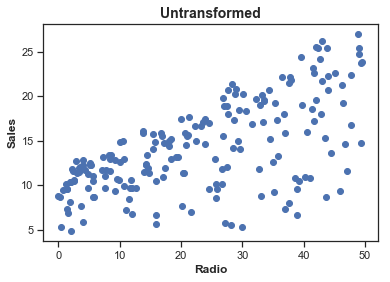

In [17]:
sns.set(style="ticks")
x = data["Radio"]
y = data["Sales"]
plt.scatter(x,y)
plt.title("Untransformed", fontweight="bold", fontsize=14)
plt.xlabel("Radio", fontweight="bold")
plt.ylabel("Sales", fontweight="bold")
plt.show()

### Transforming Sales solves some of the Heteroscedasticity, so it will remain that way from here on.

In [18]:
data["Radio"] = data["Radio"]**(1/2)
data = data[data["Radio"] > 0.2]         # just another outlier I'm removing
data["Sales"] = data["Sales"]**(1/3)

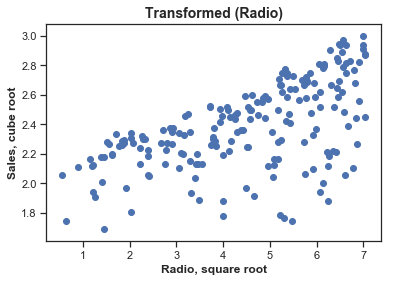

In [19]:
x = data["Radio"]
y = data["Sales"]
plt.scatter(x,y)
plt.title("Transformed (Radio)", fontweight="bold", fontsize=14)
plt.xlabel("Radio, square root", fontweight="bold")
plt.ylabel("Sales, cube root", fontweight="bold")
plt.show()

In [20]:
data["TV"] = data["TV"]**(1/2)

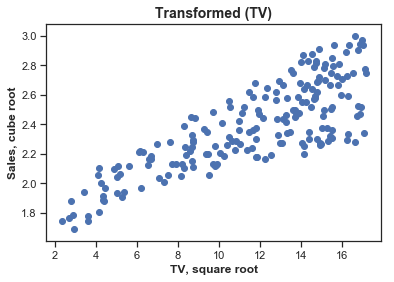

In [21]:
x = data["TV"]
y = data["Sales"]
plt.scatter(x,y)
plt.title("Transformed (TV)", fontweight="bold", fontsize=14)
plt.xlabel("TV, square root", fontweight="bold")
plt.ylabel("Sales, cube root", fontweight="bold")
plt.show()

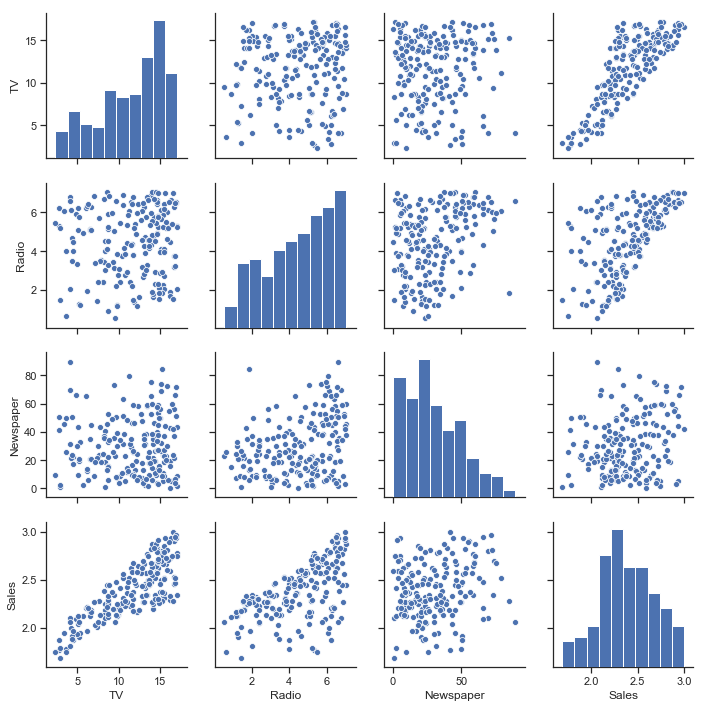

In [22]:
sns.pairplot(data)
plt.show()

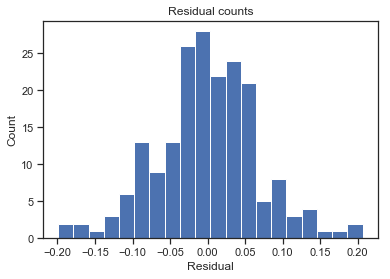

In [23]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data.loc[:, 'TV':'Newspaper']
regr.fit(X, Y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, bins=20)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

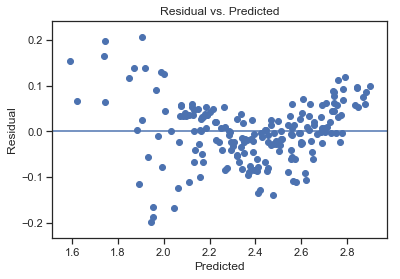

In [24]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Alright, several things here: the scedasticity has roughly the same shape as before, but with fewer extremes on the low end; also, if you compare the scales, this one is actually much tighter, varying at most +/- 0.2, rather than between 3 and -8 above.  Obviously more work could be done.  However, without correcting the wide spread of both Radio and Newspaper, this won't get too much better.